In [1]:
import matplotlib
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

%matplotlib tk
%autosave 180

#
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#
import numpy as np
import os


Autosaving every 180 seconds


<ipython-input-1-820b6af254e6>:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
################################
######### LOAD RAW DATA ########
################################

#
root_dir = 'data'
mouse_id = 'IA1'
session_id = 'May_4'

# load the raw data from each neural area
ca_data = np.load(os.path.join(root_dir,
                                 mouse_id,
                                    session_id,
                               'ca_data.npy'))
print ("ca_data [n_timesteps, n_neural_areas]: ", ca_data.shape)

# load reward_times from .txt file:
reward_times = np.loadtxt(os.path.join(root_dir,
                                    mouse_id,
                                        session_id,
                                'rewarded_times.txt'))
print (" reward_times: ", reward_times.shape)

# load the temporal shift between reward times and ca data
shift = np.load(os.path.join(root_dir,
                                    mouse_id,
                                        session_id,
                                 'start_blue.npy'),
                   allow_pickle=True)/30.
print ("shift between neural activity and behavior(seconds) ", shift)

# shift reward times by shift
reward_times = reward_times + shift



ca_data [n_timesteps, n_neural_areas]:  (40000, 30)
 reward_times:  (29,)
shift between neural activity and behavior(seconds)  1.8666666666666667


In [4]:
###################################################
##### VISUALIZE FULL SESSION + REWARD TIMES #######
###################################################

#
window_size = 10 *30   # 10 seconds

# plot d time seies
plt.figure(figsize=(12,12))
plt.suptitle("Neural activity from 10 brain areas (red lines are reward times)")


ctr=0
t = np.arange(ca_data.shape[0])/30.
stacks = []
for k in range(30):
    temp = ca_data[:,k]
    temp = temp-temp.mean()
    temp[:300]=0
    temp[-1000:]=0

    # grab a stack of 300 frames around the reward time from temp
    stack = []
    for p in range(reward_times.shape[0]):
        stack.append(temp[int(reward_times[p]*30)-window_size:int(reward_times[p]*30)+window_size])

    # make into an array
    stack = np.array(stack)
    stacks.append(stack)

    # also plot every 3rd area
    if k%3==0:
        plt.subplot(10,1,k//3+1)
        plt.plot(t, temp)

        # set xlims to first and last t
        plt.xlim(t[0], t[-1])

        #
        if ctr==27:
            plt.xlabel("Time (sec)",fontsize=12)    
        else:
            plt.xticks([])

        # plot ylabel
        plt.ylabel("Area "+str(k),fontsize=12)


        # get ymin and ymax of plot
        ymin, ymax = plt.ylim()

        
        # plot reward times as vertical lines using the ylims of the plot
        for p in range(reward_times.shape[0]):
            plt.plot([reward_times[p], reward_times[p]], 
                    [ymin, ymax], 'r--')
    #
    ctr+=1

# 
plt.show()



In [5]:
# plot average stacks for first value
plt.figure(figsize=(12,12))

#
for area_id in range(30):
    #
    plt.subplot(6,5,area_id+1)

    #
    plt.ylabel("Area "+str(area_id))

    #
    plt.yticks([])

    if area_id>=25:
        plt.xlabel("Time (sec)",fontsize=12)

    #
    temp = stacks[area_id]
    t = np.arange(temp.shape[1])/30-window_size/30

    # grab mean and std
    mean = temp.mean(0)
    std = temp.std(0)

    #
    plt.plot(t,mean, c='black')

    # plot std as shaded area
    plt.fill_between(t, mean-std, mean+std, 
                     color='black',
                     alpha=.2)

    # plot horizontal line at 0
    plt.plot([t[0], t[-1]], [0,0],'r--')


    # get max and ymin
    ymin, ymax = plt.ylim()

    # plot vertical line at 0
    plt.plot([0,0],[ymin,ymax],'r--')

plt.show()

# trials:  503
all_trials:  (503, 1800, 16)


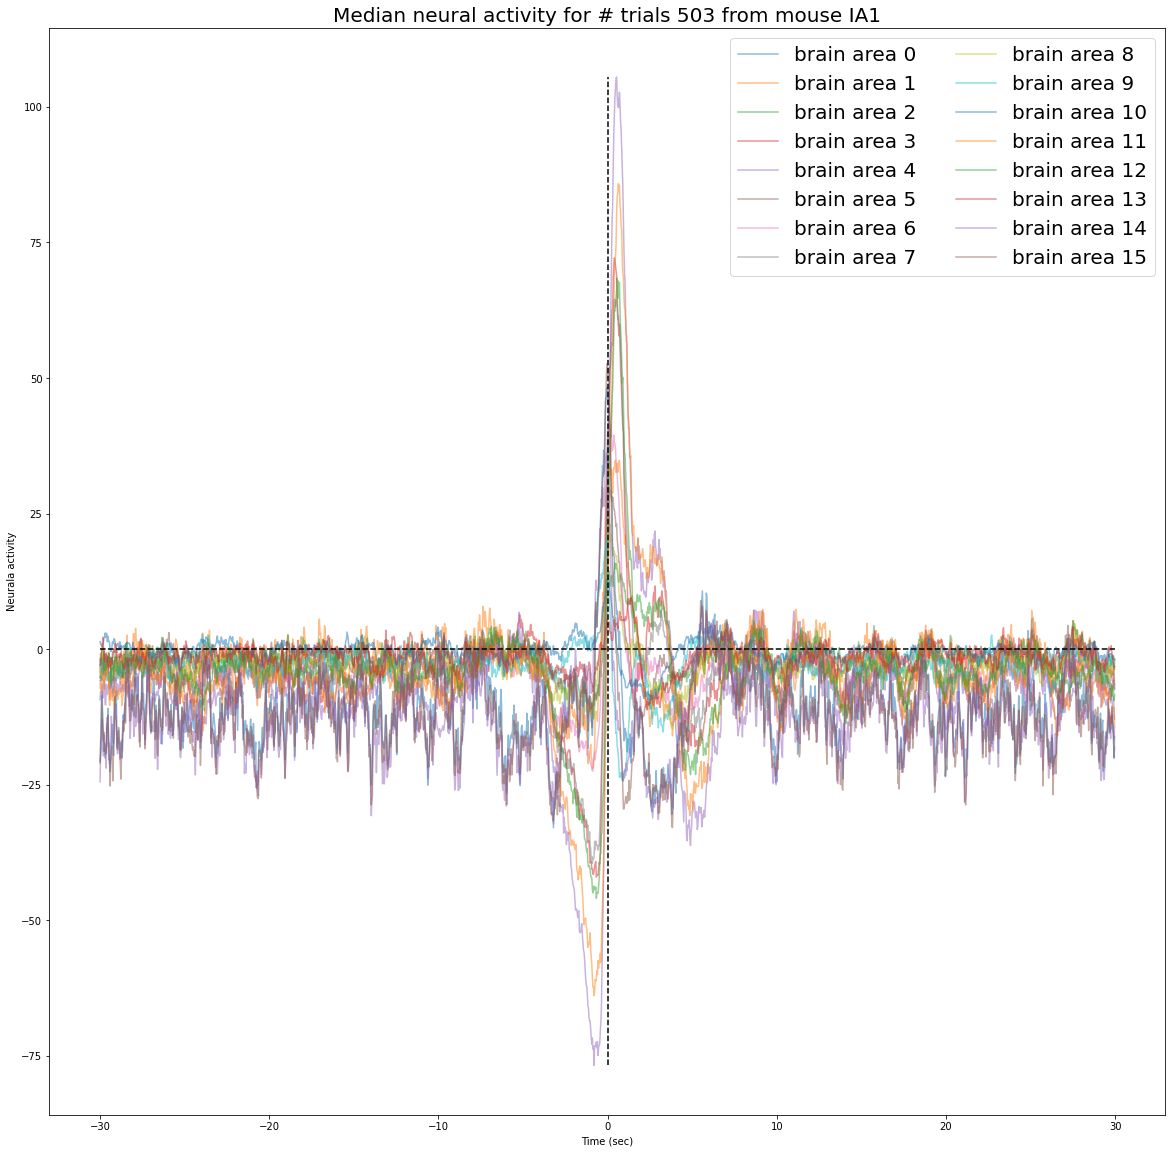

In [6]:
###################################################################
######### LOAD REWARD-CENTRED DATA AND VISUALIZE AVERAGES ######
################################################################
root_dir = '/media/cat/4TBSATA/yuki/neural_transformer_data/IA1/'

fname_trials = os.path.join(root_dir, 'trials.npy')
d = np.load(fname_trials,
            allow_pickle=True)


#count the number of trials as the first axis of d
n_trials = 0 
for k in range(d.shape[0]):
    n_trials += d[k].shape[0]
print ("# trials: ", n_trials)

# make an array of all the trials to hold data as we loop
all_trials = np.zeros((n_trials, d[0].shape[1], d[0].shape[2]), 'float32')

#
# loop over all the trials and populate the all_trials array

ctr=0
for k in range(d.shape[0]):
    for p in range(d[k].shape[0]):
        all_trials[ctr] = d[k][p]
        ctr+=1

#
print ("all_trials: ", all_trials.shape)

# plot the last trial
plt.figure(figsize=(20,20))
plt.title("Median neural activity for # trials "
          +str(all_trials.shape[0]) + " from mouse IA1",
          fontsize=20)

# make time vector t 
t = np.arange(all_trials.shape[1])/30.-30

for area_id in range(16):
    #plt.plot(all_trials[:,:,area_id].mean(0))
    plt.plot(t, np.median(all_trials[:,:,area_id], 0),
             label='brain area '+str(area_id),
             alpha=.5   )
    

# plot vertical line at t = 0 with max and min y values
plt.plot([0,0], [np.median(all_trials,0).min(), 
                 np.median(all_trials,0).max()], '--',c='black')

# same for horizontal line at y=0
plt.plot([t.min(), t.max()], [0,0], '--',c='black')

#
plt.xlabel('Time (sec)')

#
plt.ylabel("Neurala activity")

#
plt.legend(fontsize=20, ncol=2)
    
plt.show()


### Feeding data into a transformer

We are trying to feed the data into a transfomer model.

The paradigm is roughly to take each trial and feed the first last 15 seconds (from -15 sec to 0 sec) into a transfomer

So the data will be clipped below to only contain time points -15sec .. 0 sec

Then we have 2 options: predict next neural time series time point VS. predicting time to lever pull. Here we only explore the next neural time series time point. There's a separate notebook for option 2.

######################################################################

############### PREDICT NEXT NEURAL TIME SERIES POINT ################

######################################################################
#### Step 1: predict next brain activity

For each trial we take the time points and activity for each brain area and try to predict the next brain activity
- input shape [time_points, brain_area] = [450, 16]
- label: [time_points[1:], brain_area]

We could even start with single brain area
- input shape [time_points]   # for a single area this will look like a time series of length 15 x 30 = 450 time points
                              #    for example:  [30.0, 125.0, -75.3, ... ]
- label: [time_points[1:]   # so here we are predicting the input shifted by 1 [ 125.0, -75.3 ... ]

If this works we can then think about all areas.

Honestly, this is exactly what transformers are developed to do, so we shouldn't have to do too much work to adapt them. We can also smooth or bin the neural data as it's abit noisy.

The major challenges are:

1. Figure out how to convert the brain area activity - which is a float point - to a discretized value
- I think for this I'd suggest taking the range of the neural activity e.g. -200 to + 200 and creating a "vocabulary" in increments of 10. That would give us a 40 token dictionary.

2. It's not clear whether we should feed in snipeets of 15sec as explained above - or we need to randomize the location where we draw the snippets from so the transfomrer doesn't learn some average neural activity. Or maybe this is something that we want!?  Not clear.  In principle we should be able to feed in neural activity from any part of a recording (eg. 30minutes) and get a transformer to perform on this.
- We also have this data, and perhaps we should provide it.
- but for now, we're biasing ourselves by knowing the exact time of the lever pulls




In [ ]:
################################################################
############# LOAD DATA AND VISUALIZE AVERAGES #################
################################################################

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# load PCA data

#
fname = '/media/cat/4TBSATA/yuki/IA1/tif_files/IA1pm_Mar21_30Hz/IA1pm_Mar21_30Hz_whole_stack_trial_ROItimeCourses_15sec_pca30components.npy'
time = np.load(fname, allow_pickle=True)

fname = '/media/cat/4TBSATA/yuki/IA1/tif_files/IA1pm_Mar21_30Hz/IA1pm_Mar21_30Hz_whole_stack_trial_ROItimeCourses_15sec_pca30components_spatial.npy'
space = np.load(fname, allow_pickle=True)

print (time.shape)
print (space.shape)



(40000, 30)
(30, 16384)


(16, 40000)
(16,)
(16,)
(128, 128, 16)
(16,)


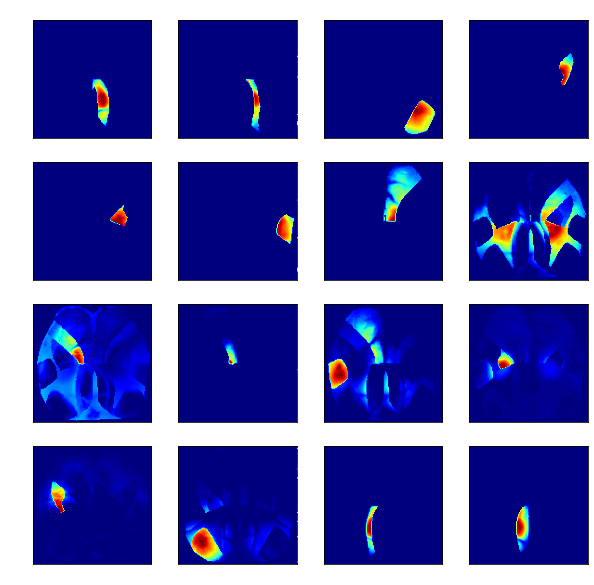

In [17]:
# load raw ROIs
fname = '/media/cat/4TBSATA/yuki/IA1/tif_files/IA1pm_Mar21_30Hz/IA1pm_Mar21_30Hz_locanmf_wholestack.npz'

data = np.load(fname, allow_pickle=True)

#
whole_stack = data['whole_stack']
print (whole_stack.shape)

#
areas = data['areas']
print (areas.shape)

#
areanames_area = data['areanames_area']
print (areanames_area.shape)

#
A_reshape = data['A_reshape']
print (A_reshape.shape)

#
names = data['names']
print (names.shape)

#
plt.figure(figsize=(10,10)) 

for k in range(16):
    plt.subplot(4,4,k+1)
    plt.imshow(A_reshape[:,:,k], 
               
               cmap='jet')
    plt.xticks([])
    plt.yticks([])

    text = names[k]

    # break up text into 2 lines half way through
    text = text[:int(len(text)/2)] + '\n' + text[int(len(text)/2):]

    plt.ylabel(text, color='white', fontsize=10)



plt.show()
